# Interactive Maps Exploring Relationships Between Fermented Vegetables and Covid-19 Mortality Rates

The original [paper](https://www.medrxiv.org/content/10.1101/2020.07.06.20147025v1) suggests that low COVID-19 death rates at the country level were linked to high fermented vegetable consumption in Europe. However, this conclusion was based on data from June 2020, an early stage of the three-year pandemic. I aim to explore whether this finding holds with the latest data using interactive maps. Additionally, I will visualize longitudinal trends in death rates or absolute death numbers.

## Load modules

In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import kaleido # This package is required to save the map as a static image

## Load and preprocess epidemiological data

### Covid 19 mortality and population data

In [168]:
# Load Covid-19 death data
covid_death_df = pd.read_csv('time_series_covid19_deaths_global.csv')

In [169]:
covid_death_df.head() 

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,7896,7896,7896,7896,7896,7896,7896,7896,7896,7896
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,3598,3598,3598,3598,3598,3598,3598,3598,3598,3598
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,165,165,165,165,165,165,165,165,165,165
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,1933,1933,1933,1933,1933,1933,1933,1933,1933,1933


The Covid-19 death data contains geographic information in the first four columns, followed by daily death counts. I will aggregate the data to get the total number of deaths and death rates per country. 

### Aggregate yearly death counts for each country

In [170]:
# Make wide table long 
covid_death_df_long = covid_death_df.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], var_name='Date', value_name='Deaths') 

In [171]:
covid_death_df_long.shape

(330327, 6)

In [172]:
covid_death_df_long['Date'].head()

0    1/22/20
1    1/22/20
2    1/22/20
3    1/22/20
4    1/22/20
Name: Date, dtype: object

In [173]:
# Add year column based on last two digits of Date column
covid_death_df_long['Date'] = pd.to_datetime(covid_death_df_long['Date'], format='%m/%d/%y', errors='coerce')


In [174]:
covid_death_df_long['Date'].head()

0   2020-01-22
1   2020-01-22
2   2020-01-22
3   2020-01-22
4   2020-01-22
Name: Date, dtype: datetime64[ns]

In [175]:
# Check missing values in Date column
covid_death_df_long['Date'].isnull().sum() 

0

In [176]:
covid_death_df_long['Year'] = covid_death_df_long['Date'].dt.year

In [177]:
# Aggregate deaths by country and year
covid_death_df_agg = covid_death_df_long.groupby(['Country/Region', 'Year'])['Deaths'].sum().reset_index()

In [178]:
covid_death_df_agg.head()

,Country/Region,Year,Deaths
0,Afghanistan,2020,296447
1,Afghanistan,2021,1778958
2,Afghanistan,2022,2810220
3,Afghanistan,2023,535810
4,Albania,2020,88375


In [179]:
# Aggregate daily death counts to get total death count
covid_death_df['Total Deaths'] = covid_death_df.iloc[:, 4:].sum(axis=1) 

In [180]:
covid_death_df['Total Deaths'].describe() 

count    2.890000e+02
mean     1.529348e+07
std      6.166454e+07
min      0.000000e+00
25%      2.474700e+04
50%      5.184140e+05
75%      5.035519e+06
max      7.138772e+08
Name: Total Deaths, dtype: float64

In [181]:
# Inspect Country/Region column
covid_death_df['Country/Region'].value_counts()

Country/Region
China             34
Canada            16
United Kingdom    15
France            12
Australia          8
                  ..
Guinea             1
Guinea-Bissau      1
Guyana             1
Haiti              1
Zimbabwe           1
Name: count, Length: 201, dtype: int64

In [182]:
# Inspect Province/State column
covid_death_df['Province/State'].value_counts()

Province/State
Australian Capital Territory    1
Saint Pierre and Miquelon       1
Reunion                         1
New Caledonia                   1
Mayotte                         1
                               ..
Gansu                           1
Fujian                          1
Chongqing                       1
Beijing                         1
Turks and Caicos Islands        1
Name: count, Length: 91, dtype: int64

There are multiple states or provinces within a country in the data. I will aggregate the data to the country level.

In [183]:
# Aggregate total deaths by country 
covid_death_country_df = covid_death_df.groupby('Country/Region')['Total Deaths'].sum().reset_index() 

In [184]:
# Sort countries by total deaths in descending order 
covid_death_country_df = covid_death_country_df.sort_values(by='Total Deaths', ascending=False) 

In [185]:
covid_death_country_df.head()

,Country/Region,Total Deaths
186,US,713877215
24,Brazil,488181000
80,India,364921237
117,Mexico,241085189
147,Russia,220983590


In [186]:
covid_death_country_df.tail()

,Country/Region,Total Deaths
5,Antarctica,0
185,Tuvalu,0
197,Winter Olympics 2022,0
170,Summer Olympics 2020,0
76,Holy See,0


In [187]:
covid_death_country_df.rename(columns={'Country/Region': 'Country'}, inplace=True)

The dataframe `covid_death_country_df` contains aggregated COVID-19 deaths at the country level from January 2020 to March 2023, used for the following visualization.

### Population data for EU countries

In [188]:
pop_df = pd.read_excel('demo_gind__custom_7680622_page_spreadsheet.xlsx', sheet_name='Sheet 1', skiprows=7)

/opt/anaconda3/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default



In [189]:
pop_df.head()

,TIME,2020,Unnamed: 2,2021,Unnamed: 4,2022,Unnamed: 6,2023,Unnamed: 8
0,GEO (Labels),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,European Economic Area (EU28 - 2013-2020 and I...,519811603,e,:,NaN,:,NaN,:,NaN
2,European Union - 27 countries (from 2020),447015600,e,445872542,b,445837374,bep,448803078,ep
3,Euro area – 20 countries (from 2023),346625682,NaN,346699769,NaN,346969818,p,349665601,p
4,Germany,83166711,NaN,83155031,NaN,83237124,NaN,84358845,NaN


In [190]:
# Clean up the population data
pop_df2 = pop_df[['TIME', '2020', '2021', '2022', '2023']]

# Drop the first row    
pop_df2 = pop_df2.drop(0)

# Rename the first column to 'Country'
pop_df2.rename(columns={'TIME': 'Country'}, inplace=True)

pop_df2.head()

,Country,2020,2021,2022,2023
1,European Economic Area (EU28 - 2013-2020 and I...,519811603,:,:,:
2,European Union - 27 countries (from 2020),447015600,445872542,445837374,448803078
3,Euro area – 20 countries (from 2023),346625682,346699769,346969818,349665601
4,Germany,83166711,83155031,83237124,84358845
5,Germany including former GDR,83166711,83155031,83237124,84358845


### Estimate death rates in 2020, 2021, 2022 and 2023 for EU countries

In [191]:
covid_death_df_agg.head()

,Country/Region,Year,Deaths
0,Afghanistan,2020,296447
1,Afghanistan,2021,1778958
2,Afghanistan,2022,2810220
3,Afghanistan,2023,535810
4,Albania,2020,88375


In [192]:
# Rename the first column to 'Country'
covid_death_df_agg.rename(columns={'Country/Region': 'Country'}, inplace=True) 

covid_death_df_agg.head()

,Country,Year,Deaths
0,Afghanistan,2020,296447
1,Afghanistan,2021,1778958
2,Afghanistan,2022,2810220
3,Afghanistan,2023,535810
4,Albania,2020,88375


In [193]:
covid_death_df_agg['Year'] = covid_death_df_agg['Year'].astype(int)

In [194]:
# Make wide table long - pop_df2
pop_df2_long = pop_df2.melt(id_vars='Country', var_name='Year', value_name='Population') 

In [195]:
pop_df2_long.head() 

,Country,Year,Population
0,European Economic Area (EU28 - 2013-2020 and I...,2020,519811603
1,European Union - 27 countries (from 2020),2020,447015600
2,Euro area – 20 countries (from 2023),2020,346625682
3,Germany,2020,83166711
4,Germany including former GDR,2020,83166711


In [196]:
pop_df2_long['Year'] = pop_df2_long['Year'].astype(int) 

In [197]:
# Merge covid_death_df_agg to pop_df2_long on Country and Year columns
covid_death_pop_df = pop_df2_long.merge(covid_death_df_agg, on=['Country', 'Year'], how='left') 


In [198]:
covid_death_pop_df.head()

,Country,Year,Population,Deaths
0,European Economic Area (EU28 - 2013-2020 and I...,2020,519811603,NaN
1,European Union - 27 countries (from 2020),2020,447015600,NaN
2,Euro area – 20 countries (from 2023),2020,346625682,NaN
3,Germany,2020,83166711,2890473.0
4,Germany including former GDR,2020,83166711,NaN


In [199]:
# Create death rate column by dividing Deaths by Population
covid_death_pop_df['Deaths'] = pd.to_numeric(covid_death_pop_df['Deaths'], errors='coerce')
covid_death_pop_df['Population'] = pd.to_numeric(covid_death_pop_df['Population'], errors='coerce')

# Fill NaN values with 0 to avoid division errors
covid_death_pop_df['Deaths'].fillna(0, inplace=True)
covid_death_pop_df['Population'].fillna(0, inplace=True)

# Calculate death rate
covid_death_pop_df['Death Rate'] = covid_death_pop_df['Deaths'] / covid_death_pop_df['Population']

/var/folders/b8/9ymtxc2j7rb00xx34s753cwc0000gn/T/ipykernel_46366/2787820439.py:6: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/var/folders/b8/9ymtxc2j7rb00xx34s753cwc0000gn/T/ipykernel_46366/2787820439.py:7: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing '

In [200]:
covid_death_pop_df.head()

,Country,Year,Population,Deaths,Death Rate
0,European Economic Area (EU28 - 2013-2020 and I...,2020,519811603.0,0.0,0.000000
1,European Union - 27 countries (from 2020),2020,447015600.0,0.0,0.000000
2,Euro area – 20 countries (from 2023),2020,346625682.0,0.0,0.000000
3,Germany,2020,83166711.0,2890473.0,0.034755
4,Germany including former GDR,2020,83166711.0,0.0,0.000000


### Fermented vegetable consumption data

In [201]:
# Read in fermented vegetable consumption data in xlsx format
food_df = pd.read_excel('Foodex 2 L4 dashboard.xlsx', skiprows=2)

In [202]:
food_df.head()

,Survey's country,Survey start year,Survey name,Population Group (L2),Exposure hierarchy (L1),Exposure hierarchy (L2),Exposure hierarchy (L3),Exposure hierarchy (L4),Number of subjects,Number of consumers,Mean,Standard Deviation,5th percentile,10th percentile,Median,95th percentile,97.5th percentile,99th percentile,Comment
0,Austria,2010,Austrian Study on Nutritional Status 2010-12 -...,Adults,Vegetables and vegetable products,Processed or preserved vegetables and similar,Fermented or pickled vegetables,Fermented vegetables,308,11,2.383117,12.625241,0,0,0,0.0,65.500000,65.500000,NaN
1,Austria,2010,Austrian Study on Nutritional Status 2010-12 -...,Elderly,Vegetables and vegetable products,Processed or preserved vegetables and similar,Fermented or pickled vegetables,Fermented vegetables,67,4,4.044776,16.201789,0,0,0,65.5,65.500000,69.977500,"'Number of observations lower than 180, the 97..."
2,Austria,2010,Austrian Study on Nutritional Status 2010-12 -...,Very elderly,Vegetables and vegetable products,Processed or preserved vegetables and similar,Fermented or pickled vegetables,Fermented vegetables,25,3,7.860000,21.723892,0,0,0,65.5,65.500000,65.500000,"'Number of observations lower than 60, the 95t..."
3,Austria,2010,Austrian Study on Nutritional Status 2010-12 -...,Adolescents,Vegetables and vegetable products,Processed or preserved vegetables and similar,Fermented or pickled vegetables,Fermented vegetables,237,8,1.485232,8.153679,0,0,0,0.0,43.666667,43.666667,"'Number of observations lower than 298, the 99..."
4,Austria,2010,Austrian Study on Nutritional Status 2010-12 -...,Other children,Vegetables and vegetable products,Processed or preserved vegetables and similar,Fermented or pickled vegetables,Fermented vegetables,128,2,0.463542,3.722254,0,0,0,0.0,0.000000,28.640000,"'Number of observations lower than 180, the 97..."


In [203]:
# Investigate countries, years, and population columns
food_df.rename(columns={"Survey's country": 'Country'}, inplace=True) 
food_df['Country'].value_counts()

Country
Netherlands                    15
France                         10
Latvia                         10
Germany                        10
Poland                          9
Austria                         8
Romania                         8
Hungary                         8
Estonia                         8
Belgium                         7
Croatia                         7
Serbia                          7
Montenegro                      6
Sweden                          6
Finland                         5
Slovenia                        5
United Kingdom                  4
Czechia                         3
Bosnia and Herzegovina          3
Bulgaria                        2
Portugal                        2
Republic of North Macedonia     2
Greece                          1
Name: count, dtype: int64

In [204]:
# Survey start year 
food_df['Survey start year'].value_counts()

Survey start year
2019    23
2012    17
2017    16
2007    15
2010    10
2014    10
2013     8
2018     8
2003     8
2006     6
2008     5
2021     4
2004     4
2011     3
2000     2
2001     2
2016     2
2015     2
1997     1
Name: count, dtype: int64

In [205]:
# Population 
food_df['Population Group (L2)'].value_counts()

Population Group (L2)
Adults             32
Elderly            24
Adolescents        24
Other children     23
Toddlers           16
Very elderly       13
Pregnant women      7
Vegetarians         4
Infants             2
Lactating women     1
Name: count, dtype: int64

Aggregated daily consumption of fermented vegetables in general population and over time by country.

In [206]:
avg_consumption_country = food_df.groupby(by ='Country')['Mean'].mean().reset_index()

avg_consumption_country.rename(columns={'Mean': 'Average Consumption'}, inplace=True)

In [207]:
avg_consumption_country.describe() # Summary statistics 

,Average Consumption
count,23.000000
mean,3.432499
std,3.132373
min,0.012646
25%,0.795268
50%,2.660731
75%,5.742800
max,10.636471


In [208]:
avg_consumption_country.head()

,Country,Average Consumption
0,Austria,2.660731
1,Belgium,0.454854
2,Bosnia and Herzegovina,5.906935
3,Bulgaria,1.235104
4,Croatia,3.958930


Prepare for geographical data of EU countries.

In [209]:
# Fetch GeoJSON for Europe
import requests
import json
    

In [210]:
# URL for countries' GeoJSON data
url = "https://raw.githubusercontent.com/datasets/geo-countries/master/data/countries.geojson"

# Fetch the data
response = requests.get(url)
geojson_data = response.json()

In [211]:
# Filter only EU countries
# eu_countries = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden']

In [212]:
targeted_countries = food_df['Country'].unique().tolist()
print(len(targeted_countries))

23


In [213]:
# Filter the geojson for EU 
eu_geojson = {
    "type": "FeatureCollection",
    "features": [
        feature for feature in geojson_data["features"]
        if feature["properties"]["ADMIN"] in targeted_countries
    ]
}

In [214]:
len(eu_geojson['features'])

20

## Data frame for the interactive map

In [215]:
# Identify EU countries in the eu_geojson
eu_countries_geojson = [feature['properties']['ADMIN'] for feature in eu_geojson['features']] 

In [216]:
print(eu_countries_geojson)

['Austria', 'Belgium', 'Bulgaria', 'Bosnia and Herzegovina', 'Germany', 'Estonia', 'Finland', 'France', 'United Kingdom', 'Greece', 'Croatia', 'Hungary', 'Latvia', 'Montenegro', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Slovenia', 'Sweden']


In [217]:
# Save en_countries_geojson as dataframe 
eu_countries_df = pd.DataFrame(eu_countries_geojson, columns=['Country']) 

In [218]:
# Merge eu_countries_df with avg_consumption_country on Country
eu_avg_consumption_country = eu_countries_df.merge(avg_consumption_country, on='Country', how='left') 

In [219]:
eu_avg_consumption_country.head()

,Country,Average Consumption
0,Austria,2.660731
1,Belgium,0.454854
2,Bulgaria,1.235104
3,Bosnia and Herzegovina,5.906935
4,Germany,1.552563


In [220]:
# Merge eu_avg_consumption_country with covid_death_pop_df on Country
eu_avg_consumption_covid_death_pop_df = eu_avg_consumption_country.merge(covid_death_pop_df, on='Country', how='left')

In [221]:
eu_avg_consumption_covid_death_pop_df.columns   

Index(['Country', 'Average Consumption', 'Year', 'Population', 'Deaths',
       'Death Rate'],
      dtype='object')

## Visually assess the relationship between fermented vegetable consumption and COVID-19 death rates

/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning:

invalid value encountered in subtract



<Figure size 1200x600 with 0 Axes>

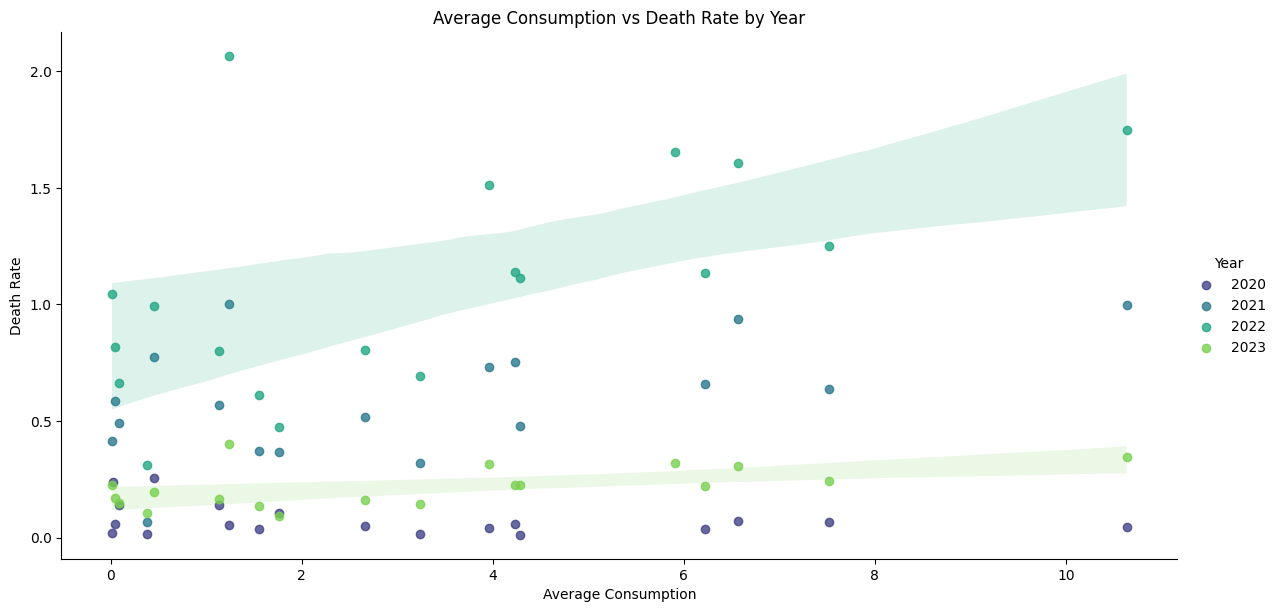

In [222]:
# Draw a scatter plot of Average Consumption vs Death Rate, stratified by Year
plt.figure(figsize=(12, 6))

# Add line of best fit by year
sns.lmplot(data=eu_avg_consumption_covid_death_pop_df, x='Average Consumption', y='Death Rate', hue='Year', palette='viridis', height=6, aspect=2)
plt.title('Average Consumption vs Death Rate by Year')

plt.show()

## Bubble map of fermented vegetable consumption in EU countries

To change the colors of the areas (countries) separately from the bubbles, use px.choropleth() for the country colors and px.scatter_geo() for the bubbles, then overlay them using go.Figure().

In [223]:
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go

In [224]:
eu_avg_consumption_covid_death_pop_df.columns 

Index(['Country', 'Average Consumption', 'Year', 'Population', 'Deaths',
       'Death Rate'],
      dtype='object')

In [225]:
eu_avg_consumption_covid_death_pop_df.head()

,Country,Average Consumption,Year,Population,Deaths,Death Rate
0,Austria,2.660731,2020,8901064.0,438345.0,0.049246
1,Austria,2.660731,2021,8932664.0,4607998.0,0.515859
2,Austria,2.660731,2022,8978929.0,7209848.0,0.802974
3,Austria,2.660731,2023,9104772.0,1476277.0,0.162143
4,Belgium,0.454854,2020,11522440.0,2931202.0,0.254391


In [226]:
# Drop rows with Inf values in Death Rate column
eu_avg_consumption_covid_death_pop_df = eu_avg_consumption_covid_death_pop_df[eu_avg_consumption_covid_death_pop_df['Death Rate'] != np.inf]

In [227]:
import pycountry

# List of EU countries
eu_countries = eu_avg_consumption_covid_death_pop_df['Country'].unique().tolist()   

# Dictionary of country names and their corresponding alpha_3 codes
country_alpha3 = {}
for country in eu_countries:
    try:
        country_data = pycountry.countries.get(name=country)
        # print(country_data.alpha_3)
        country_alpha3[country] = country_data.alpha_3
    except:
        print(f"{country} not found")

print(country_alpha3)


{'Austria': 'AUT', 'Belgium': 'BEL', 'Bulgaria': 'BGR', 'Bosnia and Herzegovina': 'BIH', 'Germany': 'DEU', 'Estonia': 'EST', 'Finland': 'FIN', 'France': 'FRA', 'United Kingdom': 'GBR', 'Greece': 'GRC', 'Croatia': 'HRV', 'Hungary': 'HUN', 'Latvia': 'LVA', 'Montenegro': 'MNE', 'Netherlands': 'NLD', 'Poland': 'POL', 'Portugal': 'PRT', 'Romania': 'ROU', 'Slovenia': 'SVN', 'Sweden': 'SWE'}


In [228]:
# Add ISO Alpha-3 codes to eu_avg_consumption_covid_death_pop_df
eu_avg_consumption_covid_death_pop_df['iso_alpha'] = eu_avg_consumption_covid_death_pop_df['Country'].map(country_alpha3)


In [229]:
data_map_2020 = eu_avg_consumption_covid_death_pop_df[eu_avg_consumption_covid_death_pop_df['Year'] == 2020]

In [230]:
# Create a Choropleth map (for country colors) based on fermented vegetable consumption
food_map = px.choropleth(
    data_map_2020,
    locations="iso_alpha",
    color="Average Consumption",
    hover_name="Country",
    scope="europe",
    projection="natural earth",
    color_continuous_scale='Plasma'
)

food_map.show()


In [231]:
data_map_2020.head()

,Country,Average Consumption,Year,Population,Deaths,Death Rate,iso_alpha
0,Austria,2.660731,2020,8901064.0,438345.0,0.049246,AUT
4,Belgium,0.454854,2020,11522440.0,2931202.0,0.254391,BEL
8,Bulgaria,1.235104,2020,6569275.0,347789.0,0.052942,BGR
16,Germany,1.552563,2020,83166711.0,2890473.0,0.034755,DEU
20,Estonia,3.232856,2020,1328976.0,20833.0,0.015676,EST


In [232]:

# df = px.data.gapminder().query("year==2007")
bubble_map = px.scatter_geo(data_map_2020,
                            locations="iso_alpha",
                            hover_name="Country",
                            size="Death Rate",
                            scope="europe",
                            projection="natural earth",
                            opacity=0.7, # Set opacity level for better visibility
                            size_max=15,
                            color_continuous_scale=px.colors.sequential.Plasma)
bubble_map.show()

In [233]:
# Combine both layers
fig = go.Figure(data=food_map.data + bubble_map.data)

In [ ]:
# Improve layout
fig.update_geos(
    scope="europe", # Only show European countries
    showcoastlines=False, 
    showland=True, 
    landcolor="lightgray",
    projection_scale=1.5)

fig.update_layout(
    coloraxis_colorbar_title="Fermented Vegetable Consumption",
    coloraxis_colorscale="RdYlBu" , # Change color scale
    width=1200,
    height=800,
    coloraxis_colorbar=dict(
        orientation="h",  # Set colorbar horizontal
        title="Fermented Vegetable Consumption",
        title_side="top",
        title_font_size=12,
        thickness=10,  # Adjust colorbar width
        len=0.5,  # Adjust colorbar height (relative size)
        x=0.25,  # Move colorbar horizontally
        y=0.95,  # Move colorbar vertically
    )
)

fig.update_layout(
    title=dict(
        text="Fermented Vegetable Consumption and Covid-19 Death Rate in Europe (2020)",
        x=0.5,  # Center the title
        y=0.98,  # Position it above the colorbar
        xanchor="center",  # Ensure proper centering
        yanchor="top",  # Anchor at the top
        font=dict(
            size=18,  # Increase font size for better readability
            family="Arial, sans-serif",  # Use a professional font
            color="black",  # Set color (adjust if needed)
            weight="bold"  # Bolden the title (alternative: use "<b>Title</b>" in text)
        )
    )
)

fig.update_layout(
    coloraxis_colorbar=dict(
        orientation="h",  # Horizontal colorbar
        x=0.5, y=-0.15,  # Move below the map
        len=0.5, thickness=10
    )
)

fig.show()

In [235]:
# Annotate country names on the map

import pandas as pd

# Create the DataFrame
country_data = pd.DataFrame({
    "Country": ["Austria", "Belgium", "Bulgaria", "Bosnia and Herzegovina", "Germany", "Estonia", "Finland", "France", "United Kingdom", "Greece", "Croatia", "Hungary", "Latvia", "Montenegro", "Netherlands", "Poland", "Portugal", "Romania", "Slovenia", "Sweden"],
    "ISO3": ["AUT", "BEL", "BGR", "BIH", "DEU", "EST", "FIN", "FRA", "GBR", "GRC", "HRV", "HUN", "LVA", "MNE", "NLD", "POL", "PRT", "ROU", "SVN", "SWE"],
    "Lat": [47.5162, 50.5039, 42.7339, 43.9159, 51.1657, 58.5953, 61.9241, 46.6034, 55.3781, 39.0742, 45.1, 47.1625, 56.8796, 42.7087, 52.1326, 51.9194, 39.3999, 45.9432, 46.1512, 60.1282],
    "Lon": [14.5501, 4.4699, 25.4858, 17.6791, 10.4515, 25.0136, 25.7482, 1.8883, -3.4360, 21.8243, 15.2, 19.5033, 24.6032, 19.3744, 5.2913, 19.1451, -8.2245, 24.9668, 14.9955, 18.6435]
})

# Display the DataFrame
print(country_data)

                   Country ISO3      Lat      Lon
0                  Austria  AUT  47.5162  14.5501
1                  Belgium  BEL  50.5039   4.4699
2                 Bulgaria  BGR  42.7339  25.4858
3   Bosnia and Herzegovina  BIH  43.9159  17.6791
4                  Germany  DEU  51.1657  10.4515
5                  Estonia  EST  58.5953  25.0136
6                  Finland  FIN  61.9241  25.7482
7                   France  FRA  46.6034   1.8883
8           United Kingdom  GBR  55.3781  -3.4360
9                   Greece  GRC  39.0742  21.8243
10                 Croatia  HRV  45.1000  15.2000
11                 Hungary  HUN  47.1625  19.5033
12                  Latvia  LVA  56.8796  24.6032
13              Montenegro  MNE  42.7087  19.3744
14             Netherlands  NLD  52.1326   5.2913
15                  Poland  POL  51.9194  19.1451
16                Portugal  PRT  39.3999  -8.2245
17                 Romania  ROU  45.9432  24.9668
18                Slovenia  SVN  46.1512  14.9955


In [236]:
import plotly.graph_objects as go

# Create the country label layer (scattergeo)
country_labels = go.Scattergeo(
    locationmode="ISO-3",
    lon=country_data["Lon"],
    lat=country_data["Lat"],
    text=country_data["Country"],  # Display country names
    mode="text",  # Only text (no markers)
    textfont=dict(size=12, color="black", family="Arial", weight="bold"),  # Adjust font
    textposition="top center",  
    showlegend=False
)

# Add to your existing Plotly figure
fig.add_trace(country_labels)


In [237]:
# Save the Plotly figure as HTML file  
pio.write_html(fig, file='index.html', auto_open=True)